In [ ]:
!pip3 install keras==2.1.0

In [ ]:
import os 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from zipfile import ZipFile
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
import random
import cv2
from sklearn.model_selection import KFold
from imgaug import augmenters as iaa
import glob
%tensorflow_version 1.x
import tensorflow as tf
import keras as k

print(tf.test.gpu_device_name())
print('tensorflow = ', tf.__version__) 
print('keras = ', k.__version__)

TensorFlow 1.x selected.
/device:GPU:0
tensorflow =  1.15.2
keras =  2.1.0


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Model Building and Dataset Preperation

In [ ]:
### Download Mask_RCNN Model
!rm -rf sample_data
!rm -rf Mask_RCNN
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

## Download weights // Transfer Learning
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 26.06 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
#os.chdir('Mask_RCNN')
import sys
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

In [ ]:
## load final_csv.csv file that you should get after running fashion_preprocessing.ipynb successfully
image_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/final_csv.csv' , converters={'EncodedPixels': eval, 'ClassId' :eval})
image_df_new = image_df_new[image_df_new.ImageId.isin(os.listdir('/content/drive/MyDrive/fashion_data/ImageTrain'))]
print(len(image_df_new))

22155


In [ ]:
## At inference time your model must know the configuration that was used while training
## hence run this cell even if you are inferencing.

## Fahion config

NUM_CATS = 20
IMAGE_SIZE = 512
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 
    BACKBONE = 'resnet50'   
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'   
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    STEPS_PER_EPOCH = 500 ## ***
    VALIDATION_STEPS = 200 ## **

config = FashionConfig()

class_label = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'shorts', 'skirt', 'coat', \
               'dress', 'glasses', 'hat', 'headband, head covering, hair accessory', 'watch', 'belt', 'tights,\
                stockings', 'sock', 'shoe', 'bag, wallet', 'zipper', 'rivet', 'ruffle']


In [ ]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

def resize_mask(img, mask) :  ## will be used while testing/inferencing
    return cv2.resize(mask, (img.shape[0], img.shape[1]), interpolation=cv2.INTER_NEAREST)

## Data set 
## load_image and load_mask fuctions must be present
class FashionDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)
        # Add classes
        for i, name in enumerate(class_label):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.ImageId, 
                           path=str('/content/drive/MyDrive/fashion_data/ImageTrain/'+row.ImageId), 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def get_path(self, image_id) :
        return self.image_info[image_id]['path']

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                start_pixel -= 1
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)


In [ ]:
FOLD = 3
N_FOLDS = 5
LR = 1e-3
EPOCHS = [8, 20, 35]   ## **
#EPOCHS = [1, 2, 3]
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df_new)

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df_new.iloc[train_index], image_df_new.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

In [ ]:
augmentation = iaa.Sometimes(0.3, iaa.OneOf([
        iaa.Fliplr(0.5), 
        iaa.Flipud(0.5), # vertical flips
        iaa.ContrastNormalization((0.75, 1.5))]
    )
)


#Traning

In [ ]:
from keras import backend as K
K.clear_session()

try :
    del model
except :
    print('You are good to go')

model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/Mask_RCNN')
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
!rm -rf fashion*
model.train(train_dataset, valid_dataset,
            learning_rate= LR * 2, 
            epochs=EPOCHS[0], ## **
            layers='heads',
            augmentation=None)  ## **
history = model.keras_model.history.history



Starting at epoch 0. LR=0.002

Checkpoint Path: /content/Mask_RCNN/fashion20210306T1846/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history

for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 8. LR=0.001

Checkpoint Path: /content/Mask_RCNN/fashion20210306T1846/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=(LR/2),
            epochs=EPOCHS[2],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 20. LR=0.0005

Checkpoint Path: /content/Mask_RCNN/fashion20210306T1846/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b 

In [ ]:
## Save weights and history file

#history_df = pd.DataFrame(history)
#history_df.to_csv('/content/drive/MyDrive/fashion_data/history.csv')
#!mv fashion* fashion_weights
#!cp -r 'fashion_weights' '/content/drive/MyDrive/fashion_data/fashion_weights2' 

In [ ]:
## Loading the saved weights for Inference and performance metric calculation

!rm -rf fashion_weights
#!cp -r '' 'fashion_weights'
!cp -r '/content/drive/MyDrive/fashion_data/history.csv' 'history.csv'
history = pd.read_csv('history.csv')
best_epoch = np.argmin(list(history["val_loss"])) + 1
print(best_epoch)
model_path = '/content/drive/MyDrive/fashion_data/fashion_weights2/mask_rcnn_fashion_{best_epoch:04d}.h5'.format(best_epoch = best_epoch)

24


In [ ]:

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BATCH_SIZE = 1

inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir= '/content/Mask_RCNN')

print("Loaded weights from ", model_path)
model.load_weights(model_path, by_name=True)

#Inference 

In [ ]:
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir= '/content/Mask_RCNN')

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
%%time
def get_inference_info(ID) :
    image_path = valid_dataset.get_path(ID)
    result = model.detect([resize_image(image_path)])
    r = result[0]
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)    
    else:
        masks, rois = r['masks'], r['rois']
    class_ids, scores = r['class_ids'], r['scores']
    return img, rois, masks, class_ids, scores


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


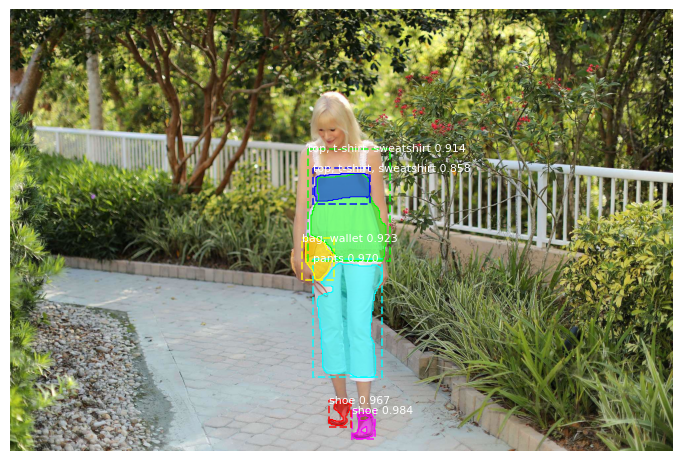

In [ ]:
img, rois, masks, class_ids, scores = get_inference_info(random.randint(0, len(valid_df) - 1))
visualize.display_instances(img, rois, masks, class_ids, 
                            ['bg']+class_label, scores,
                            figsize=(12, 12))

###Calculating Map Score 
Perfomance metrics are tools used to evaluate usability of the model. The model wont be that much useful if it is not performing well. We are going to use "Mean Average Precision" as performance metric. First we thought of using IOU score but later realized that IOU score not useful to measure the performance of instance segmentation task. Lets understand it through example, suppose we have modelX which only recognizes bigger instances of an object, if we use IOU as a metric we will get pretty high metric score, because IOU of bigger object will dominate the metric so, here there are no ways for us to know whether our model is doing something useful or not.
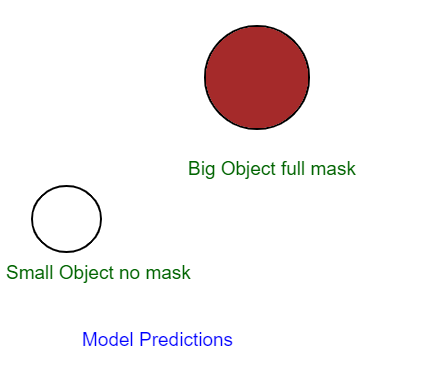

To deal with the above problem we will use mean average precision metric, how to calculate Map is little complex process lets understand it step by step. In Map we consider different IOU thresholds such as [0.5, 0.55, 0.6, ...0.95]. At each threshold we calculate TP, FP and FN  we will later use these values to calulate the precision score using the following formula precision score = [TP / (TP + FP + FN)]. We know what are TP, FP, FN in the context of two class classification problem something similar we will define here but in the context of images. I will explain them using cat = positive class = 1 , dog = negative class = 0 analogy. <br> <br>
A)TP means model got the the object correctely IOU >= threshold [cat predicted as cat]<br>
B)FP means model detected some class but the detected class was not present in the image [dog predicted as cat or IOU < threshold] <br>
C)FN means model failed to detect the class which was present in the image [cat predicted as dog] <br> <br>
It deals with the problem that we were facing in case of IOU score because at some threshold the condition "IOU > Threshold" will be false, FP will be increased and it will penalize the model. First I thought of  combining the mask of predicted and actual instances of perticular class for some image into single image and then calucating IOU between combined actual and predicted masks. This calculated IOU will be used when metric runs over different threshold to get TP, FP and FN values but this method has flaws. To understand the flaw lets take two models model1, model2 as shown in below figure the IOU of both models will the same and hence Map score will also be the same but if you think intuitively you will immediately know that model2 is far better than model1 but using the this method we cant make out model1 from model2.
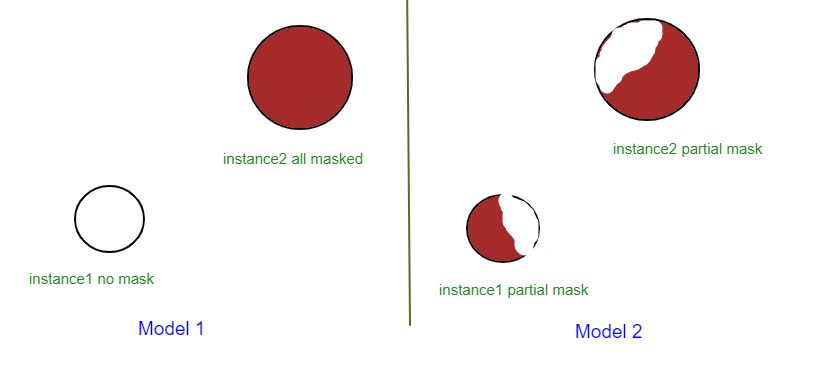


The above problem can be solved by keeping predicted and actual masks of each instance of an object seperately. So, in this schemes for example for above case we will have 4 seperate IOUs each one giving/increasing any one of the following value TPs, FPs or FNs unlike previous method where for each object we were having single IOU. Using this method if you calulate the Map you will get higher value for model2.
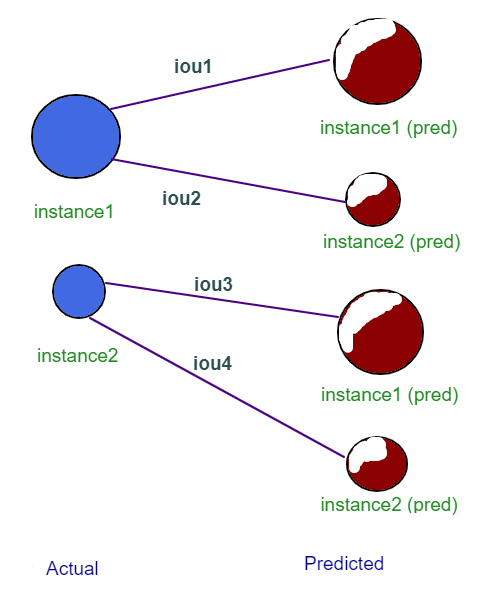

Finally I have used below Map algorithm to calculate the Map score.
<br> <br>score = (TP/(TP + FP +FN)) <br> AP = (score1 + score2 + score3)/3 <br> Mean AP (Map) = (AP1 + AP2 + AP3) / 3 <br> <br>
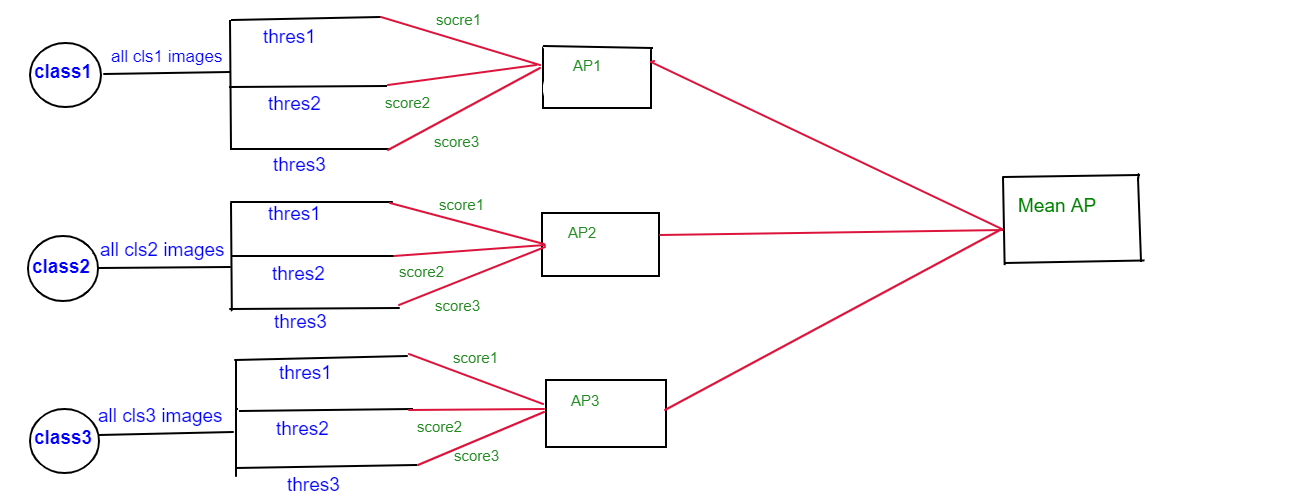

In [ ]:
## Implementating Map
col_pred = ['pred_image_id', 'pred_class_id', 'pred_mask']
col_actual = ['actual_image_id', 'actual_class_id', 'actual_mask']
pred_df = pd.DataFrame(data = None, columns = col_pred)
actual_df = pd.DataFrame(data = None, columns = col_actual)

for id in tqdm(range(0, 1000)) : ## ***
    img, rois_pred, mask_pred, class_ids_pred, scores_pred = get_inference_info(id)
    mask_actual, class_ids_actual = valid_dataset.load_mask(id)

    for i, cls in enumerate(class_ids_pred):
        mask = mask_pred[:, :, i]
        mask = cv2.resize(mask.astype('uint8'), (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
        pred_df = pred_df.append(pd.DataFrame([[id, cls, mask]], columns = col_pred), ignore_index = True)

    for i, cls in enumerate(class_ids_actual) :
        mask = mask_actual[:, :, i]
        actual_df = actual_df.append(pd.DataFrame([[id, cls, mask]], columns = col_actual), ignore_index = True)


100%|██████████| 1000/1000 [20:04<00:00,  1.20s/it]


In [ ]:
final_df = pd.merge(pred_df, actual_df, how = 'outer', left_on = ['pred_image_id', 'pred_class_id'], right_on = ['actual_image_id', 'actual_class_id'])
final_df.head()

,pred_image_id,pred_class_id,pred_mask,actual_image_id,actual_class_id,actual_mask
0,0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
def IOU(mask_tuple):
    A = mask_tuple[0]
    B = mask_tuple[1]
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

In [ ]:
## Note np.nan that is present in either pred_mask or actual_mask 
## is considered as True in IOU function for logical or / logical and it could mess things up 
## so pass the masks to IOU functions only if both are not nan.

idx = (final_df.pred_mask.notnull() & final_df.actual_mask.notnull()) 
iou = final_df[idx][['pred_mask', 'actual_mask']].apply(IOU, axis = 1)
final_df.loc[idx, 'IOU'] = iou
final_df.head()

,pred_image_id,pred_class_id,pred_mask,actual_image_id,actual_class_id,actual_mask,IOU
0,0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.672026
1,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.000000
2,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.824682
3,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.737935
4,0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,16,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.000276


In [ ]:
scores_class_level = []
for cls in range(1, 21) : ## Total 20 classes [1 to 20]
    scores_threshold_level = []  
    temp_df = final_df[(final_df.pred_class_id == cls) | (final_df.actual_class_id == cls)] 
    if len(temp_df) != 0 :
        fp = temp_df.actual_class_id.isnull().sum()   ## Model detected the class but class was not present in the  image
        fn = temp_df.pred_class_id.isnull().sum()   ## Model failed to detect the class which was present in the image
        for threshold in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9] :
            tp = (temp_df.IOU >= threshold).sum()
            fp_iou = (temp_df.IOU < threshold).sum()   ## false positive through threshold 
            fp_final = fp + fp_iou
            score = tp / (tp + fp_final + fn)
            scores_threshold_level.append(score)
        scores_class_level.append(np.mean(scores_threshold_level))

print('Map Score =', np.mean(scores_class_level))

Map Score = 0.2058516045212801
